<a href="https://colab.research.google.com/github/Jeffrowetull/DS-Unit-4-Sprint-1-NLP/blob/master/LS_DS_415_Sprint_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Sprint Challenge
## *Data Science Unit 4 Sprint 1*

After a week of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset/challenge). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). I've sampled the data for you to something more managable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. As you work on the challenge, I suggest adding notes about your findings and things you want to analyze in the future.

## Challenge Objectives
*Successfully complete these all these objectives to earn a 2. There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

In [0]:
import pandas as pd

yelp = pd.read_json('/content/review_sample.json', lines=True)

In [2]:
yelp.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- accept one document at a time
- return a list of tokens

You are free to use any method you have learned this week.

In [0]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

In [0]:
def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [0]:
yelp['token'] = yelp['text'].map(tokenize)

## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews
2. Write a fake review and query for the 10 most similiar reviews, print the text of the reviews. Do you notice any patterns?
    - Given the size of the dataset, it will probably be best to use a `NearestNeighbors` model for this. 

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

data=[]
for _ in list(yelp.token):
  data.append(' '.join(_))
  
tf = TfidfVectorizer(max_features=5000,stop_words='english',min_df=5)

dtm=tf.fit_transform(data)
df_tf=pd.DataFrame(dtm.todense(),columns=tf.get_feature_names())
df_tf.head()

,ability,able,absolute,absolutely,ac,accent,accept,acceptable,accepted,access,accessible,accessories,accident,accidentally,accommodate,accommodated,accommodating,accomodating,accompanied,according,account,accurate,acknowledge,acknowledged,acne,acrylic,act,acted,action,active,activities,activity,acts,actual,actually,ad,adam,add,added,addicted,...,wrote,wtf,www,wynn,ya,yard,yay,yea,yeah,year,years,yell,yelled,yelling,yellow,yellowtail,yelp,yelpers,yep,yes,yesterday,yikes,yo,yoga,yogurt,yolk,yonge,york,young,younger,yr,yuck,yum,yummy,yup,zero,zone,zoo,zucchini,était
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.155473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.101824,0.0,0.0,0.0,0.0,0.0,0.066552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.188463,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5,algorithm='ball_tree')
nn.fit(dtm.todense())

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [32]:
fake=['I love america and I love food']
fake_trans = tf.transform(fake).todense()
nn.kneighbors(fake_trans,n_neighbors=10)

(array([[1.        , 1.        , 1.07534832, 1.11725818, 1.16411773,
         1.16445549, 1.17197596, 1.17602705, 1.18554887, 1.1863195 ]]),
 array([[6204, 6311,  967, 3693, 9173, 8362, 8789,  540, 5526, 2705]]))

In [0]:
def insert_newlines(string, every=64):
    return '\n'.join(string[i:i+every] for i in range(0, len(string), every))

In [33]:
l=[6204, 6311,  967, 3693, 9173, 8362, 8789,  540, 5526, 2705]
for i in l:
  print(insert_newlines(string=data[i],every=150))

探したお店でした とても気に入りました
天氣很熱吃不下東西 今天我點了一個韓國冷面湯 餐後點了甜點 冰沙系列不會太甜膩 覺得店家很用心製作 包含擺盤精緻 佐料衛生 夏日想開胃 這是一個不錯的選擇 服務人員也很敬業 以後會常常來
love love love place food wonderful wait staff bar friendly couldn ask love new expansion bar area think good italian food pick arrivedercis won dissa
ppointed
love yc good price
arepas place fun delicious maybe sucker food latin america love arepa chorizo tostones firmly believe latin place loud energetic
love place shimp dish amazing order plate table worth try love
love place dearly best friend india took time loved enjoyed service authentic food quit peaceful meal friend told food closest thing tried america clo
se home cooked traditional indian entree
place home az love love food authentic delicious hit place time highly recomend
love coming combination worlds awesome place fantastic service pretty good food amazing love coming
love place great food love hamburger meatloaf fish specials like relaxed old club like atmosphere love eddie


* I need to clean out oriental languages
* love is very popular

## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a piepline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier. Use that pipeline to estimate a model to predict `stars`. Use the Pipeline to predict a star rating for your fake review from Part 2. 
2. Tune the entire pipeline with a GridSearch

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

In [0]:
vect = TfidfVectorizer(stop_words='english')
sgdc = SGDClassifier()

pipe = Pipeline([('vect',vect),('clf', sgdc)])

In [0]:
features = 'token'
target = 'stars'

In [50]:
pipe.fit(yelp['text'],yelp[target])

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patte...
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
           

In [53]:
pipe.predict(['I love america and I love food', 'hello'])

array([5, 1])

In [0]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (10, 50, 80),
}

In [0]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(pipe, parameters, cv=5,
                    n_jobs=-1, verbose=1)

grid.fit(yelp['text'],yelp[target])


In [56]:
print('best score: %0.3f'% grid.best_score_)
print('Best parameters set:')
best_parameters = grid.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

best score: 0.616
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 50
	clf__penalty: 'l2'
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)


In [57]:
grid.predict(['I love america and I love food'])

array([5])

## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. Refer to yesterday's notebook to extract. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

In [0]:
import numpy as np
import gensim

from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

In [0]:
id2word = corpora.Dictionary(yelp['token'])

In [0]:
id2word.filter_extremes(no_below=5, no_above=0.75)

In [0]:
corpus = [id2word.doc2bow(text) for text in yelp['token']]

In [0]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   num_topics=10,
                   passes=10,
                   workers=2)

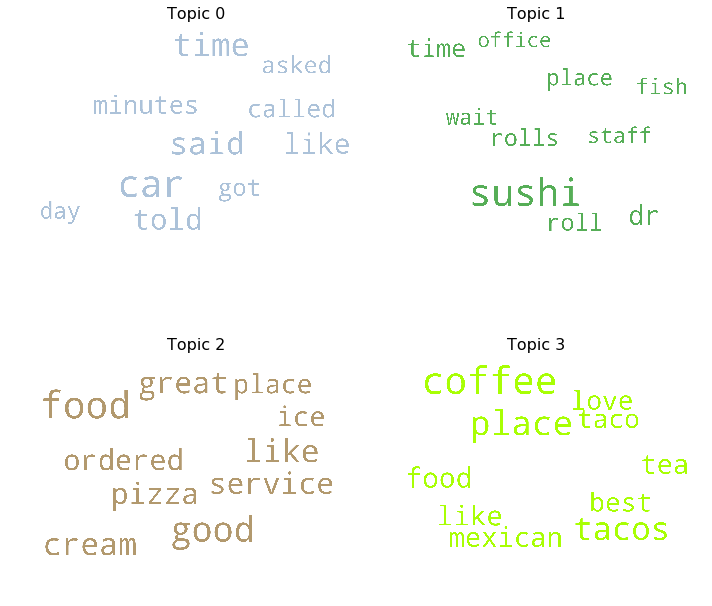

In [66]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()]

cloud = WordCloud(background_color='white',
                 width=2500,
                 height=1800,
                 max_words=10,
                 colormap='tab10',
                 color_func=lambda *args, **kwargs: cols[i],
                 prefer_horizontal=1)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
  fig.add_subplot(ax)
  topic_words = dict(topics[i][1])
  cloud.generate_from_frequencies(topic_words, max_font_size=300)
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic '+str(i), fontdict=dict(size=16))
  plt.gca().axis('off')
  
  
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0,y=0)
plt.tight_layout()
plt.show()

In [67]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook


topic_weights = []
for row_list in lda[corpus]:
  tmp=np.zeros(10)
  for i, w in row_list:
    tmp[i]=w
  topic_weights.append(tmp)

  
arr = pd.DataFrame(topic_weights).fillna(0).values


arr = arr[np.amax(arr, axis=1) > 0.35]


topic_num = np.argmax(arr, axis=1)


tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.XKCD_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9572 samples in 0.053s...
[t-SNE] Computed neighbors for 9572 samples in 1.008s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9572
[t-SNE] Computed conditional probabilities for sample 2000 / 9572
[t-SNE] Computed conditional probabilities for sample 3000 / 9572
[t-SNE] Computed conditional probabilities for sample 4000 / 9572
[t-SNE] Computed conditional probabilities for sample 5000 / 9572
[t-SNE] Computed conditional probabilities for sample 6000 / 9572
[t-SNE] Computed conditional probabilities for sample 7000 / 9572
[t-SNE] Computed conditional probabilities for sample 8000 / 9572
[t-SNE] Computed conditional probabilities for sample 9000 / 9572
[t-SNE] Computed conditional probabilities for sample 9572 / 9572
[t-SNE] Mean sigma: 0.006820
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.487915
[t-SNE] KL divergence after 1000 iterations: 1.051627


Loading BokehJS ...

In [0]:
!pip install pyLDAvis

In [72]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda,corpus,id2word)

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.140171  0.023504       1        1  20.128407
4     -0.091083 -0.039974       2        1  13.819991
6      0.004972  0.065467       3        1  11.255831
2      0.155882  0.049953       4        1  10.521131
8     -0.135919 -0.020399       5        1   9.343107
5     -0.080682 -0.012398       6        1   9.154924
9      0.117468  0.045535       7        1   8.699981
0     -0.149443 -0.018837       8        1   6.446129
3      0.121704 -0.169444       9        1   6.125278
1     -0.083071  0.076594      10        1   4.505228, topic_info=     Category         Freq        Term        Total  loglift  logprob
138   Default  4993.000000        food  4993.000000  30.0000  30.0000
99    Default   949.000000        room   949.000000  29.0000  29.0000
729   Default   488.000000       sushi   488.000000  28.0000  28.0000
196   Default  4270.000000       great  4270.000000  27.0000  27.0000
1858  Default   636.000000         car   636.000000  26.0000  26.0000
1081  Default   610.000000      coffee   610.000000  25.0000  25.0000
1937  Default   535.000000      burger   535.000000  24.0000  24.0000
1668  Default   446.000000       hotel   446.000000  23.0000  23.0000
714   Default   542.000000       cream   542.000000  22.0000  22.0000
172   Default  1251.000000        menu  1251.000000  21.0000  21.0000
1132  Default  1436.000000     chicken  1436.000000  20.0000  20.0000
340   Default  1247.000000   delicious  1247.000000  19.0000  19.0000
374   Default   779.000000       pizza   779.000000  18.0000  18.0000
2260  Default   310.000000       tacos   310.000000  17.0000  17.0000
197   Default   398.000000        hair   398.000000  16.0000  16.0000
1365  Default   603.000000       fries   603.000000  15.0000  15.0000
367   Default  1553.000000       order  1553.000000  14.0000  14.0000
499   Default   974.000000        told   974.000000  13.0000  13.0000
2281  Default   244.000000          dr   244.000000  12.0000  12.0000
29    Default  1221.000000        said  1221.000000  11.0000  11.0000
131   Default  1004.000000         bar  1004.000000  10.0000  10.0000
24    Default   926.000000     minutes   926.000000   9.0000   9.0000
982   Default   489.000000        beer   489.000000   8.0000   8.0000
418   Default   831.000000    customer   831.000000   7.0000   7.0000
718   Default   454.000000         ice   454.000000   6.0000   6.0000
1122  Default  1567.000000     ordered  1567.000000   5.0000   5.0000
611   Default  1395.000000  restaurant  1395.000000   4.0000   4.0000
39    Default  4673.000000        good  4673.000000   3.0000   3.0000
330   Default   826.000000      cheese   826.000000   2.0000   2.0000
183   Default  1363.000000     amazing  1363.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
2487  Topic10    28.770136      dental    50.306686   2.5411  -6.5500
2660  Topic10    23.989161    practice    45.379799   2.4625  -6.7318
1582  Topic10    39.592827    japanese   104.782646   2.1267  -6.2307
687   Topic10    53.682827        park   175.729385   1.9141  -5.9263
35    Topic10   129.752640        wait   970.610718   1.0876  -5.0438
230   Topic10    78.541466          pm   397.606049   1.4781  -5.5458
2340  Topic10    54.671612      salmon   215.381638   1.7289  -5.9080
1249  Topic10    86.305740        care   530.489258   1.2840  -5.4515
45    Topic10   124.949997       staff  1554.390015   0.5790  -5.0815
400   Topic10    90.436600       asked   843.362122   0.8672  -5.4047
33    Topic10   168.530304        time  3434.456055   0.0854  -4.7823
624   Topic10    56.412216        rude   330.928650   1.3307  -5.8767
24    Topic10    85.598816     minutes   926.103149   0.7186  -5.4597
125   Topic10   101.179718      people  1437.651733   0.4461  -5.2925
499   Topic10    80.342003        told   974.620178   0.6042  -5.5231
382   Topic10    70

Ok, my first two visualizations don't really tell me anything, they just look cool. The distance map is very useful though. First of all, it's showing me some words that don't really add to topic definition like place, good, great, and food.  Second, looking at the topic clouds that are in similar space is pretty cool as well.  There are three in the top right that sound like they're from fancy sitdown restaurants. While number ten is in the top left and it clearly describes sushi restaurants. Number nine in the bottom right describes Mexican restaurants and interestingly features coffee. I think number six is describing Vegas dining.

## Stretch Goals

Complete one of more of these to push your score towards a three: 
* Incorporate named entity recognition into your analysis
* Compare vectorization methods in the classification section
* Analyze more (or all) of the yelp dataset - this one is v. hard. 
* Use a generator object on the reviews file - this would help you with the analyzing the whole dataset.
* Incorporate any of the other yelp dataset entities in your analysis (business, users, etc.)